_Instructions from Prechtel_

It requires a series of steps just to get the intersection points of a graticule. It requires 10-15 lines of code only to produce such intersection points in a defined lat/long interval. Simply write the point data to a file with the help of pyshp using a nested loop (one for lat, one for long). O.k. the geodetic buffering – the subsequent step of Aileen’ solution - is truly a nice feature of ESRI software. However, if one has projection rules and parameters already available (from literature), one may construct ellipses without much of an effort (just as an approximation by going round the centre in small angular steps). This seems manageable with classical simple projections (those which allow a geometric construction) but I confess it will become rather demanding once the transformation from geographic coordinates into the map space can only done with the help of complex mathematical formulas. I will certainly not expect a comprehensive treatment including hundreds of projections in your project! Just provide two or three basic ones.

This task can definitely be implemented using a Python script.
Since the calculation is obviously depending on the Spatial Reference System, I would propose that you try to implement the generation of the Tissot ellipses only for a very small number of projections. If you organise it in a way, that you delegate the calculation of the ellipse axes (actually the diagram of distortion) to a projection-specific function, you can later on add as many more as you need or want.
In order to provide some ideas on how such an implementation could be efficiently structured (more intelligent solutions are always welcome), I would start with a user-defined segment of the Earth’s surface (minLat, maxLat, minLong, maxLong), and a desired grid spacing (e.g. 10°/10°) for the calculation. The second user-dependent parameter is the choice of a spatial reference (let’s say for instance Mercator). Then, the lat/long distortion can be calculated at any grid intersection using the function in charge, and probably one more principal function could draw the ellipses using the two axis lengths of the indicatrix.
This is neither trivial nor super complicated. I am just a bit uncertain about the type of graphic output to be generated. It could be elliptical polylines (approximated may be by quite a number of vertices along the elliptical arc?) to be stored as shapes or feature classes in a geo-database? Use the simplest solution of graphic output. Do not care about the background layer (like political borders or whatever). You have a wide choice in ESRI and QGIS software. This is completely off-the-shelf content.
It is up to you whether you will make use of the ESRI arcpy interface or not. If you decide for this project topic, you can obviously discuss intermediate stages again with me.

Steps 
1. Collect Data from Either the ESRI Database or the Natural Earth Data
2. Read in data
3. Follow
4. Choose Projections -- Mercator, Robinson


In [171]:
import pandas as pd 
import numpy as np
import shapefile

import geopandas as gpd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from shapely.geometry import Polygon, Point, LineString

In [2]:
input_dir = 'data/'
output_dir = 'data/output/'
sf_name = "ne_110m_admin_0_countries.shp"

In [3]:
sf = shapefile.Reader(input_dir + 'ne_110m_admin_0_countries/' + sf_name)

## Helper Fuctions

In [4]:
def get_base(input_dir, sf_name):
    
    base_map=gpd.read_file(input_dir + sf_name)
    base_map.plot()
    extremes = base_map.geometry.bounds
    
    return base_map, extremes


In [38]:
# Copied from https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_grid(grid_degree=None):
    if grid_degree is None:
        selected_grid_degree = 30
    else: 
        grid_options = [1,5,10,30]
        if grid_degree not in grid_options:
            selected_grid_degree = find_nearest(grid_options, grid_degree)
            print("Given option not available, setting degree to closest level, {}".format(selected_grid_degree))
        else:
            selected_grid_degree = grid_degree
    graticules = gpd.read_file(input_dir + "ne_50m_graticules_all/ne_50m_graticules_{}.shp".format(selected_grid_degree))
    return graticules

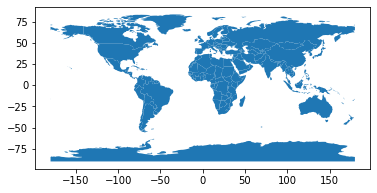

In [34]:
base_map, extremes = get_base(input_dir, "ne_110m_admin_0_countries/" + sf_name)

Given option not available, setting degree to closest level, 30


<AxesSubplot:>

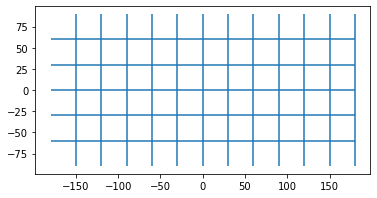

In [43]:
# Read Graticules instead of calculating them
graticules = get_grid(grid_degree=21)
graticules.plot()
grid = graticules

In [146]:
# SWAP TO THIS EVENTUALLY
# def create_grid(base_map, degree=50): 
#     """Create a grid of given degree across the bounds of the map """

#     points = base_map.geometry
#     xmin, ymin, xmax, ymax = points.total_bounds

#     length = degree
#     wide = degree

#     cols = list(np.arange(xmin, xmax + wide, wide)) 
#     rows = list(np.arange(ymin+length, ymax+length, length)) # skip extremes on North and South Poles

#     polygons = []
#     for x in cols[:-1]:
#         for y in rows[:-1]:
#             #polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
#             #polygons.append(LineString([Point(x, y), Point(x+wide, y+length)]))
#             polygons.append(LineString([Point(x, y), Point(x+wide, y)]))
#             polygons.append(LineString([Point(x, y), Point(x, y+length)]))


#     grid = gpd.GeoDataFrame({'geometry':polygons})
#     return grid 

# grid = create_grid(base_map)
# grid.plot()

In [158]:
def create_intersection_points(grid): 

    intersections_df = pd.DataFrame(columns=["geometry"])
    intersections = []

    gdf = grid
    
    # Iterate through each row and find intersection points , Modified from https://gist.github.com/maptastik/dc3d3b4514546310500a13fb77663bb9 
    for index, row in gdf.iterrows():
        row_intersections = gdf.intersection(row['geometry'])         # Get GeoSeries of intersections of row with all rows
        intersections.extend(row_intersections[row_intersections.geom_type == 'Point'].geometry)         # Keep only point intersections
        t = pd.DataFrame(intersections, index=None)

    t = t.rename({0: 'Coordinates'}, axis=1) # Fix to turn back into Geodataframe
    graticule_intersections_gdf = gpd.GeoDataFrame(t, geometry="Coordinates")
    graticule_intersections_gdf = graticule_intersections_gdf.set_crs(epsg=4326)
    return graticule_intersections_gdf


In [159]:
graticule_intersections_gdf = create_intersection_points(grid)


## Initial Plotting

<AxesSubplot:>

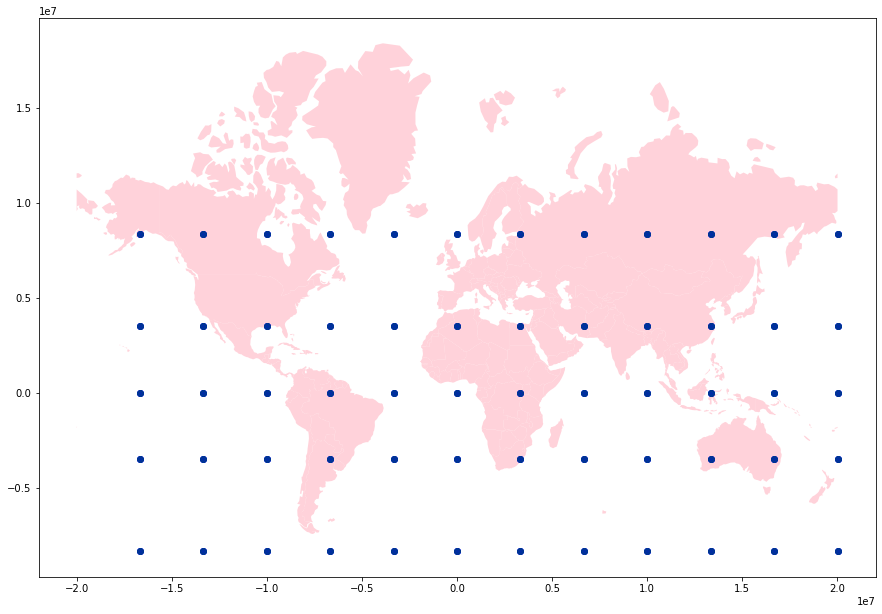

In [254]:
bm = base_map.to_crs(epsg=3395)
gi= graticule_intersections_gdf.to_crs(epsg=3395)
bm = bm[(base_map.ADMIN != "Antarctica") & (base_map.ADMIN != "Fr. S. Antarctic Lands")] # want to remove 

fig, ax = plt.subplots(figsize=(15, 15))

bm.plot(ax=ax, alpha=0.7, color="pink")

gi.plot(ax=ax, color="blue")
buffered_gi = gi.copy()
b = gi.geometry.buffer(.9) # create buffers
buffered_gi['geometry'] = b
buffered_gi.plot(ax=ax, color="green", alpha=.2)
grid.plot(ax=ax)
 ## NEED TO FIX THE BUFFERS 


## Generate Ellipsoids  -- WHERE I AM COMPLETELY LOST



http://www2.hawaii.edu/~matt/104/Exercises/projections.html

_I would start with a user-defined segment of the Earth’s surface (minLat, maxLat, minLong, maxLong), and a desired grid spacing (e.g. 10°/10°) for the calculation. The second user-dependent parameter is the choice of a spatial reference (let’s say for instance Mercator). Then, the lat/long distortion can be calculated at any grid intersection using the function in charge, and probably one more principal function could draw the ellipses using the two axis lengths of the indicatrix._

https://gis.stackexchange.com/questions/5068/how-to-create-an-accurate-tissot-indicatrix

"We have the BOUNDS from the geopandas database
we have the CRS from the GPD 
We need to calculate the graticules at the user defined degrees and create a geopandas table composed only of the graticule intersections

Then for each intersection have the function that creates the buffer https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html

Then apply the specified projection to the buffer


obtain dx/d(phi) at a point (phi, lambda), ask your GIS to project the points

(phi - h/2, lambda) --> (x0,y0),
(phi + h/2, lambda) --> (x1,y1).
Use the estimates

dx / d(phi) = (x1 - x0)/h,
dy / d(phi) = (y1 - y0)/h.
Similarly, project the points

(phi, lambda - h/2) --> (x2,y2), # x2, y2 = (phi, lambda - h/2)
(phi, lambda + h/2) --> (x3,y3) # x3, y3 = (phi, lambda + h/2)
and use the estimates

dx / d(lambda) = (x3 - x2)/h,
dy / d(lambda) = (y3 - y2)/h."

In [334]:
def obtain_scale_factors(graticule_intersections_gdf, output_proj_epsg, h=None):
    """
    REDO TO BE POINT BASED ON DF BASED??
    phi  = latitude
    lambda = longitude


    y = projected latitude
    x = projected longidue 
    """
    if h is None: 
        h = 10**(-5.2) 
        
    lats = graticule_intersections_gdf.geometry.y
    lons = graticule_intersections_gdf.geometry.x
    
    proj_code = output_proj_epsg #epsg code of the output projection 
    base_code = 4326

    h = 10**(-5.2) 

    first_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats - h/2, lons)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code) #lat = point[0], lon = point[1]
    second_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats + h/2, lons)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)
    third_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats, lons - h/2)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)
    fourth_proj = gpd.GeoSeries([Point(Point(point[0], point[1])) for point in zip(lats, lons + h/2)], crs="EPSG:{}".format(base_code)).to_crs(epsg = proj_code)

    x0s, y0s = first_proj.geometry.x, first_proj.geometry.y
    x1s, y1s = second_proj.geometry.x, second_proj.geometry.y
    x2s, y2s = third_proj.geometry.x, third_proj.geometry.y
    x3s, y3s = fourth_proj.geometry.x, fourth_proj.geometry.y

    dx_phi = (x1s - x0s)/h 
    dy_phi = (y1s - y0s) /h
    dx_lambda = (x3s - x2s)/h
    dy_lambda = (y3s - y2s)/h


    # Adjust based on  reference system https://en.wikipedia.org/wiki/World_Geodetic_System#:~:text=The%20WGS%2084%20datum%20surface,%3D%201%2F298.257223563.
    world_radius = {
        4326: 6378137
    }

    R = world_radius[base_code]

    # Cylindrical Projection
    if output_proj_epsg == 3395: 

        scale_factor_h = (y3s - y2s)/ (R * h) # along meridian 
        scale_factor_k  = (x3s - x2s)/((R * np.cos(lats.values))* h) # along parallel 
    
    
    return scale_factor_h, scale_factor_k



In [344]:
def fake_scale_factors(graticule_intersections_gdf):
    """
    THIS IS FAKES SOME DEGREE OF DISTORTION TO TEST THE MAPPING PORTION LATER. 
    """
        
    lats = graticule_intersections_gdf.geometry.y
    lons = graticule_intersections_gdf.geometry.x
    
    scale_factor_h = [1 for lon in lons]
    scale_factor_k = [1 + abs(lat) / 20 for lat in lats]
    return scale_factor_h, scale_factor_k

In [345]:
# scale_factor_h, scale_factor_k = obtain_scale_factors(graticule_intersections_gdf, output_proj_epsg=3395, h=None)
scale_factor_h, scale_factor_k = fake_scale_factors(graticule_intersections_gdf)

## Drawing Ellipses

In [ ]:
## DRAW THE ELLIPSE GIVEN THE COORDINATES https://gis.stackexchange.com/questions/243459/drawing-ellipse-with-shapely
#cgraticule_intersections_gdf.rename(columns ={'0':'geometry'}, inplace=True)
#cindicatrix = intersections.geometry.buffer(.01) WHAT IF YOU CREATED THE BUFFER FIRST AND THEN MULTIPLIED IT

In [346]:
indicatrices = []
ellipses = []
for index, row in graticule_intersections_gdf.to_crs(epsg=3395).iterrows():
    x = row['Coordinates'].x
    y = row['Coordinates'].y
    base_size = 382688 # 6% of world radius 6378137 * .06
    x_scale = scale_factor_h[index] # along meridians
    y_scale = scale_factor_k[index] # along paralelles 
    e = Ellipse((x,y), base_size * x_scale , base_size * y_scale)
    if index is 0:
        print('x: {}, y: {}, x_scale: {},  y_scale: {} '.format(x,y,base_size*x_scale, base_size*y_scale))
    ellipses.append(e)
    # Transform into Polygon 
    vertices = e.get_verts()     # get the vertices from the ellipse object
    poly = Polygon(vertices)
    indicatrices.append(poly)
    

x: 20037134.473352976, y: 8362401.529585934, x_scale: 382688,  y_scale: 1530726.4295914918 


In [347]:
t = pd.DataFrame(indicatrices, index=None)
t = t.rename({0: 'Coordinates'}, axis=1) # Fix to turn back into Geodataframe
ti = gpd.GeoDataFrame(t, geometry="Coordinates")
ti = ti.set_crs(epsg=proj_code)


<AxesSubplot:>

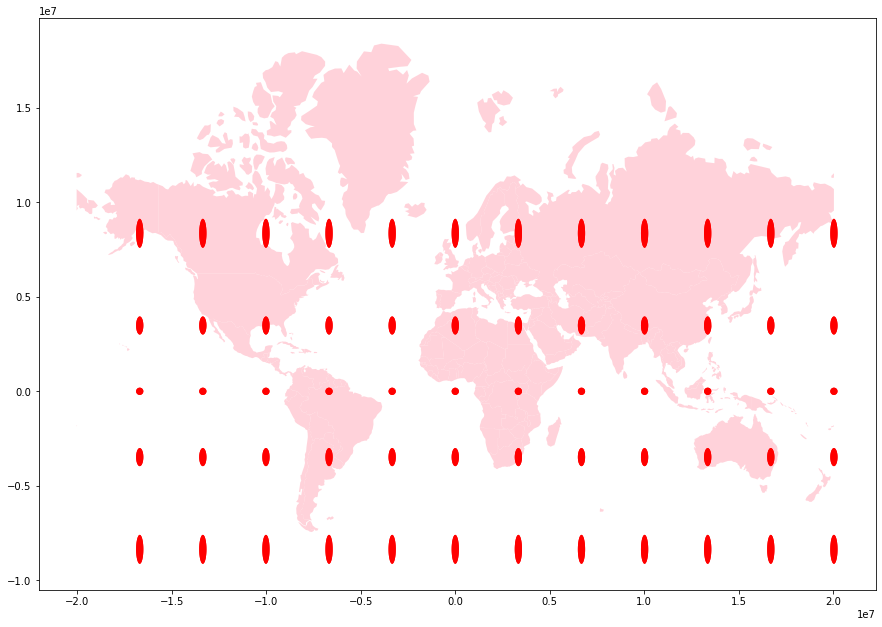

In [348]:
bm = base_map.to_crs(epsg=3395)
gi= graticule_intersections_gdf.to_crs(epsg=3395)
bm = bm[(base_map.ADMIN != "Antarctica") & (base_map.ADMIN != "Fr. S. Antarctic Lands")] # want to remove 

fig, ax = plt.subplots(figsize=(15, 15))
bm.plot(ax=ax, alpha=0.7, color="pink")
grid.plot(ax=ax)
#gi.plot(ax=ax, color="blue")
ti.plot(ax=ax, color="red")
 ## NEED TO FIX THE BUFFERS 


## To Implement

In [10]:
def calculate_tissots_indicatrix(lat_min, lat_max, lon_min, lon_max, deg, projection):
    """
    
    Parameters
    ----------
    
    
    
    Returns
    ----------
    
    gpd: A geopandas GeoDataFrame
    
    """
    return None

In [ ]:
def display_save_tissots_indicatrix(base_map_layer, indicatrix_layer, ti_size=None, output_fname):
    """
    
    Plots the overlaid and exports the TI layer to a shapefile
    
    Parameters
    ----------
    base_map_layer: 
    
    indicatrix_layer:
    
    ti_size: int
        Integer representing the proportion of hte map the base TI should be 
    
    output_fname
    
    
    
    
    
    Returns
    ----------
    
    None
    
    """
    
    fig, ax = plt.subplots(figsize=(15, 15))
    base_map_layer.plot(ax=ax, alpha=0.7, color="pink")
    
    if ti_size is not None:
        buffered_indicatrix = indicatrix_layer.geometry.buffer(ti_size)
        buffered_indicatrix.plot(alpha=0.2, ax=ax)
    else:
        indicatrix_layer.plot(ax=ax)
    
    
    fig.show()
    return None 